# Yankees - Propensity Event- Tier 1 to 5
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Feb 01, 2022

## Hypothesis


## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '54.164.224.129'  
DATABASE = 'stlrRays' 
USERNAME = 'nrad' 
PASSWORD = 'Y34@PSc^n@JAG=4%p8194'#getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 53 # Yankees

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrYankees].[ds].[getPropensityEventScoring] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"]) 

CNXN.commit()
cursor.close()

df.shape

(1065064, 46)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065064 entries, 0 to 1065063
Data columns (total 46 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   lkupClientId            1065064 non-null  int64  
 1   dimCustomerMasterId     1065064 non-null  int64  
 2   dimEventId              1065064 non-null  int64  
 3   inMarket                1065064 non-null  int64  
 4   customerNumber          1065064 non-null  object 
 5   year                    1065064 non-null  int64  
 6   productGrouping         1065064 non-null  object 
 7   Tier                    1065064 non-null  int64  
 8   eventDay                1065064 non-null  int64  
 9   totalSpent              1065064 non-null  float64
 10  recentDate              1065064 non-null  object 
 11  attendancePercent       1065064 non-null  float64
 12  renewedBeforeDays       1065064 non-null  int64  
 13  isBuyer                 1065064 non-null  object 
 14  so

### We should specify the features used in our model:

In [9]:
# choose the features for the stellar base retention model
features = ["dimCustomerMasterId",
        "inMarket",
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "distToVenue",
        "totalGames",
        "recency",
        "click_link",
        "fill_out_form",
        "open_email" ,
        "send_email",
        "unsubscribe_email",
        "openToSendRatio",
        "clickToSendRatio",
        "clickToOpenRatio",
        "Tier",
        "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]
#df_dataset = df_dataset[df_dataset["Tier"] == {1,2,3} ]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (755505, 19)
Unseen Data For Predictions: (133324, 19)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [10]:
setup(
    data= df_train, 
    target="Tier", 
    train_size = 0.80,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","year"],
    silent=True,
    verbose=False,
    numeric_features=["inMarket",
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "distToVenue",
        "totalGames",
        "recency",
        "click_link",
        "fill_out_form",
        "open_email" ,
        "send_email",
        "unsubscribe_email",
        "openToSendRatio",
        "clickToSendRatio",
        "clickToOpenRatio"
    ]
);

In [11]:
model_matrix = compare_models(
    fold=10,
    include=["xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.4537,0.7082,0.3580,0.4854,0.4282,0.2406,0.2541,113.8090


In [12]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4529,0.7085,0.3572,0.4833,0.4272,0.2395,0.2527
1,0.4520,0.7086,0.3565,0.4850,0.4260,0.2378,0.2520
2,0.4550,0.7086,0.3573,0.4847,0.4291,0.2423,0.2555
3,0.4529,0.7060,0.3567,0.4860,0.4269,0.2390,0.2526
4,0.4525,0.7064,0.3568,0.4858,0.4265,0.2386,0.2524
5,0.4557,0.7098,0.3597,0.4879,0.4308,0.2435,0.2572
6,0.4520,0.7085,0.3565,0.4833,0.4257,0.2379,0.2514
7,0.4555,0.7086,0.3598,0.4860,0.4305,0.2432,0.2566
8,0.4538,0.7084,0.3598,0.4861,0.4287,0.2408,0.2543
9,0.4553,0.7089,0.3601,0.4857,0.4302,0.2430,0.2562


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [13]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(176235, 46)

In [14]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,dimEventId,inMarket,customerNumber,year,productGrouping,Tier,eventDay,totalSpent,...,unknown,credits_after_refund,NumberofGamesPerSeason,isNextGameBuyer,Label,Score_1,Score_2,Score_3,Score_4,Score_5
888829,53,162,866,0,10605279,2021,Online Individual Game,6,7,88.0,...,0,0.0,94,0,2,0.0878,0.5584,0.0357,0.3071,0.0111
888830,53,174,904,1,11896281,2021,Online Individual Game,6,2,65.0,...,0,0.0,94,0,1,0.5078,0.1907,0.1374,0.1615,0.0026
888831,53,439,913,1,1213275,2021,Online Individual Game,3,7,170.0,...,0,0.0,94,0,1,0.4579,0.2717,0.0454,0.2159,0.0091
888832,53,439,1260,1,1213275,2021,Online Individual Game,6,3,0.0,...,0,0.0,94,0,3,0.0214,0.1790,0.6963,0.0921,0.0111
888833,53,822,905,1,10605691,2021,Online Individual Game,4,7,660.0,...,0,0.0,94,0,4,0.0616,0.3458,0.0209,0.5492,0.0225


In [15]:
new_predictions["Label"].value_counts()

4    61539
2    48678
1    33440
3    29829
5     2749
Name: Label, dtype: int64

In [16]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    125909
(0.2, 0.4]        28347
(0.4, 0.6]        15741
(0.6, 0.8]         5381
(0.8, 1.0]          857
Name: Score_1, dtype: int64

In [17]:
new_predictions["Score_2"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(0.2, 0.4]       104292
(-0.001, 0.2]     53895
(0.4, 0.6]        17596
(0.6, 0.8]          448
(0.8, 1.0]            4
Name: Score_2, dtype: int64

In [18]:
new_predictions["Score_3"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    102355
(0.2, 0.4]        57212
(0.4, 0.6]         8862
(0.6, 0.8]         6934
(0.8, 1.0]          872
Name: Score_3, dtype: int64

In [19]:
new_predictions["Score_4"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(0.2, 0.4]       96118
(-0.001, 0.2]    44469
(0.4, 0.6]       28813
(0.6, 0.8]        6268
(0.8, 1.0]         567
Name: Score_4, dtype: int64

In [20]:
new_predictions["Score_5"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    164918
(0.2, 0.4]         9796
(0.4, 0.6]          781
(0.6, 0.8]          491
(0.8, 1.0]          249
Name: Score_5, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

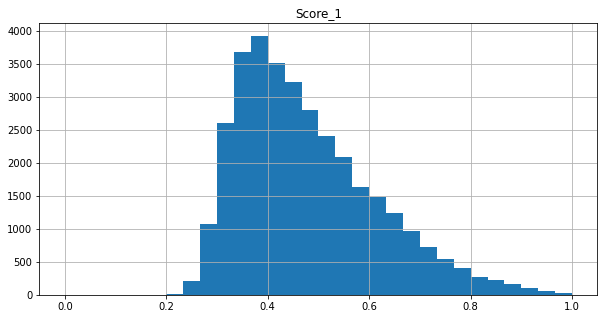

In [21]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

array([[<AxesSubplot:title={'center':'Score_2'}>]], dtype=object)

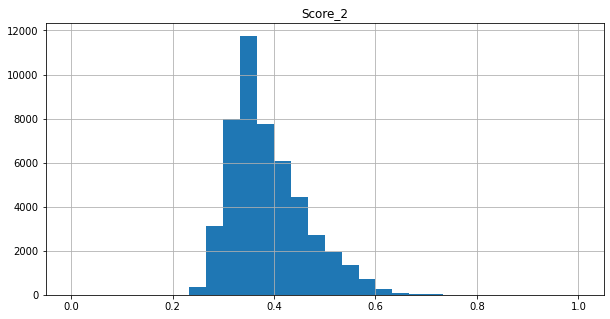

In [22]:
new_predictions[new_predictions["Label"]==2][["Score_2"]].hist(bins=30, figsize=(10,5), range=[0,1])

array([[<AxesSubplot:title={'center':'Score_3'}>]], dtype=object)

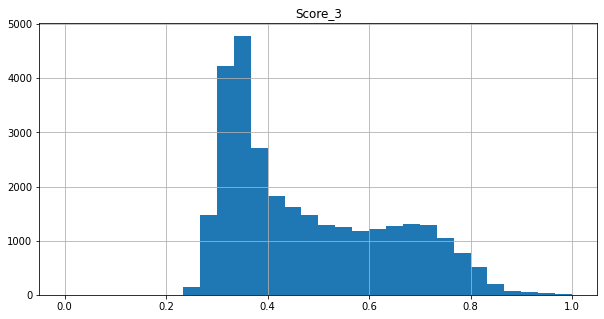

In [23]:
new_predictions[new_predictions["Label"]==3][["Score_3"]].hist(bins=30, figsize=(10,5), range=[0,1])

array([[<AxesSubplot:title={'center':'Score_4'}>]], dtype=object)

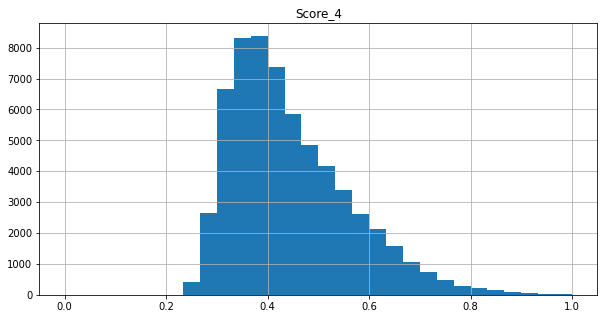

In [24]:
new_predictions[new_predictions["Label"]==4][["Score_4"]].hist(bins=30, figsize=(10,5), range=[0,1])

array([[<AxesSubplot:title={'center':'Score_5'}>]], dtype=object)

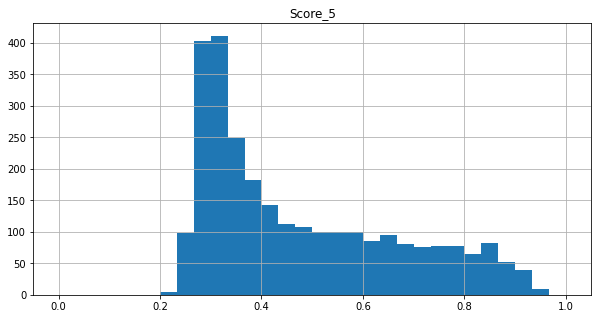

In [25]:
new_predictions[new_predictions["Label"]==5][["Score_5"]].hist(bins=30, figsize=(10,5), range=[0,1])

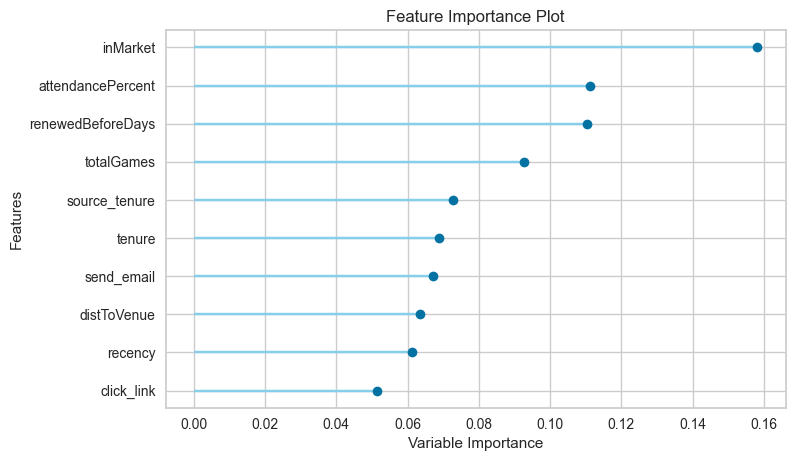

In [26]:
plot_model(best_model, plot='feature')

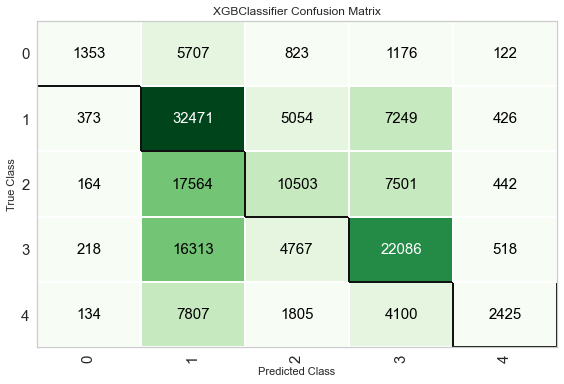

In [27]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?

* We should ask CS/CI what they think the most significant factor towards a next game buyer is.